# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

*by Дьяченко Елизавета М8О-312Б-23*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [10]:
X_train = np.loadtxt("sample_data/train/X_train.txt")
y_train = np.loadtxt("sample_data/train/y_train.txt").astype(int)

X_test = np.loadtxt("sample_data/test/X_test.txt")
y_test = np.loadtxt("sample_data/test/y_test.txt").astype(int)

In [11]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

assert (X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert (X_test.shape == (2947, 561) and y_test.shape == (2947,))

n_classes = len(np.unique(y_train))
n_classes

(7352, 561) (2947, 561)
(7352,) (2947,)


6

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [12]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [13]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [14]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(10299, 561)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [16]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(10299, 65)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

**Ответ:**
- 65

In [17]:
len(pca.explained_variance_ratio_)

65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

**Ответ:**
- 51

In [18]:
round(pca.explained_variance_ratio_[0] * 100)

51

Визуализируйте данные в проекции на первые две главные компоненты.

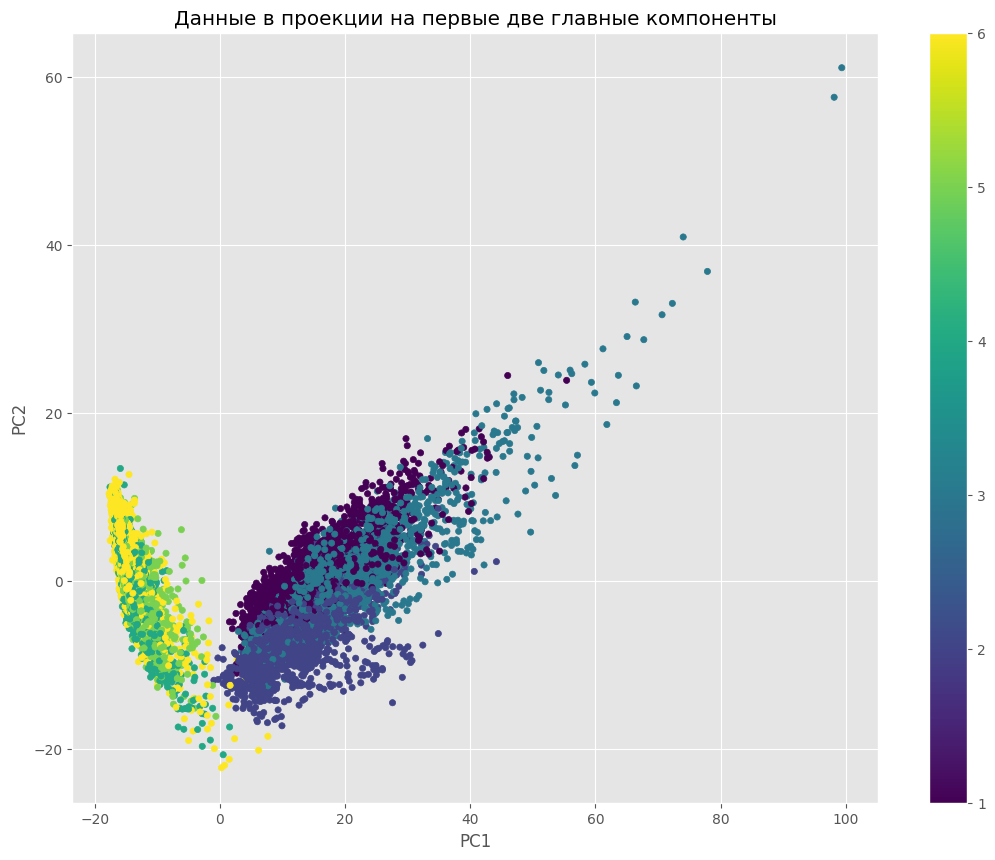

In [19]:
plt.figure(figsize=(13, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title('Данные в проекции на первые две главные компоненты');

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 2 кластера: (ходьба, подъём и спуск по лестнице) и (сидение, стояние, лежание)


------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [20]:
k_means = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
k_means.fit(X_pca)
cluster_labels = k_means.labels_
np.unique(cluster_labels), len(cluster_labels)

(array([0, 1, 2, 3, 4, 5], dtype=int32), 10299)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

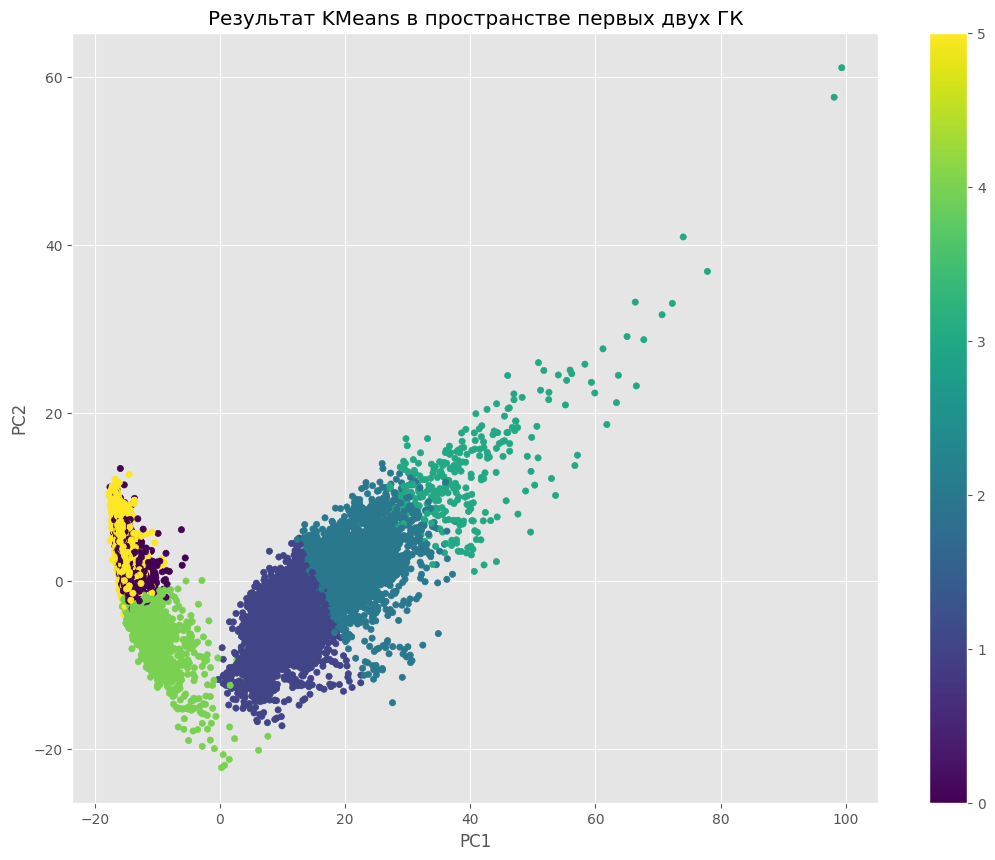

In [21]:
plt.figure(figsize=(13, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title('Результат KMeans в пространстве первых двух ГК');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [35]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Варианты:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

**Ответ:**
- перечисленные варианты не подходят

In [22]:
contingency = pd.crosstab(y, cluster_labels)
display(contingency)

best_fraction_per_class = contingency.max(axis=1) / contingency.sum(axis=1)
best_fraction_per_class

col_0,0,1,2,3,4,5
row_0,,,,,,
1,0,903,741,78,0,0
2,0,1241,296,5,2,0
3,0,320,890,196,0,0
4,1235,1,0,0,450,91
5,1344,0,0,0,562,0
6,52,5,0,0,329,1558


,0
row_0,
1,0.524390
2,0.803756
3,0.633001
4,0.694992
5,0.705142
6,0.801440


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [23]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(
        n_clusters=k,
        n_init=100,
        random_state=RANDOM_STATE
    )
    kmeans.fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

for i in range(1, len(inertia) - 1):
    D = abs(inertia[i] - inertia[i + 1]) / abs(inertia[i - 1] - inertia[i])
    print(D)

/tmp/ipython-input-1430805371.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

0.1734475356009447
0.4168855575586198
0.9332198909748728
0.6297014287707658


**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [36]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [37]:
ari_ag = metrics.adjusted_rand_score(y, ag.labels_)
ari_km = metrics.adjusted_rand_score(y, cluster_labels)
ari_ag, ari_km

(0.49362763373004886, 0.4198070012602345)

**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответ:** все три утверждения верны

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((7352, 561), (2947, 561))

In [27]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [28]:
grid = GridSearchCV(
    svc,
    param_grid=svc_params,
    cv=3
)
grid.fit(X_train_scaled, y_train)

best_svc = grid.best_estimator_
best_score_full = grid.best_score_
best_svc, best_score_full, grid.best_params_

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(LinearSVC(C=0.1, random_state=17), np.float64(0.9379785010699506), {'C': 0.1})

In [29]:
metrics.accuracy_score(y_test, best_svc.predict(X_test_scaled))

0.9619952494061758

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.1

In [30]:
y_predicted = best_svc.predict(X_test_scaled)

In [31]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Варианты:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

**Ответ:**
- верного ответа нет (по точности – стояние, по полноте – сидение)

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [32]:
# PCA на масштабированных train/test
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

X_train_scaled_pca.shape, X_test_scaled_pca.shape

((7352, 63), (2947, 63))

In [33]:
grid_pca = GridSearchCV(
    svc,
    param_grid=svc_params,
    cv=3
)
grid_pca.fit(X_train_scaled_pca, y_train)

best_score_pca = grid_pca.best_score_

best_score_full, best_score_pca, round((best_score_full - best_score_pca) * 100)

(np.float64(0.9379785010699506), np.float64(0.8983982658750974), 4)

**Ответ:** **4%**


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ:**
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

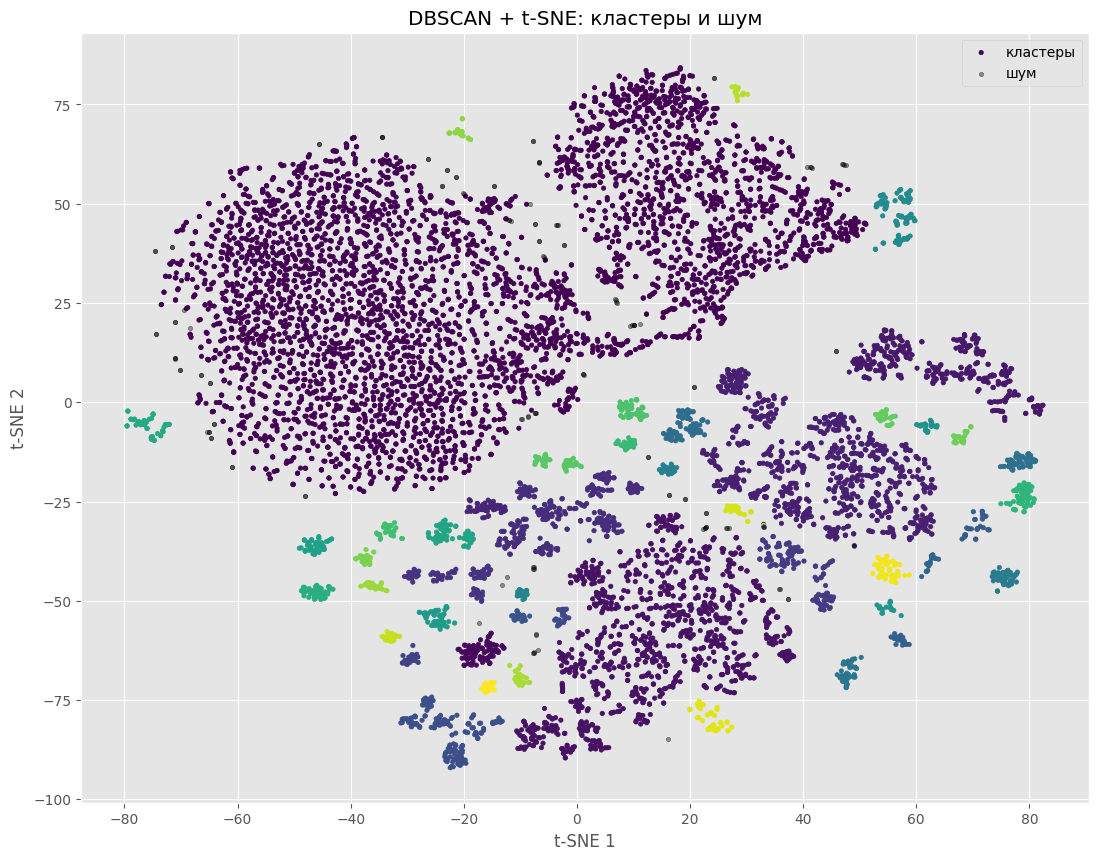

In [39]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# t-SNE до 2D на уже отмасштабированных признаках
tsne = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    perplexity=30,
    learning_rate=200,
    init="random"
)
X_tsne = tsne.fit_transform(X_scaled)

# DBSCAN поверх t-SNE-представления
dbscan = DBSCAN(eps=3, min_samples=10)
db_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(13, 10))

# Не-шум (кластеры)
mask_core = db_labels != -1
plt.scatter(
    X_tsne[mask_core, 0],
    X_tsne[mask_core, 1],
    c=db_labels[mask_core],
    s=10,
    cmap='viridis',
    label='кластеры'
)

# Шум (label = -1) – рисуем серым/чёрным
mask_noise = db_labels == -1
plt.scatter(
    X_tsne[mask_noise, 0],
    X_tsne[mask_noise, 1],
    s=10,
    alpha=0.4,
    color='black',
    label='шум'
)

plt.title("DBSCAN + t-SNE: кластеры и шум")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend();

В этой визуализации видно, что t-SNE гораздо лучше разделяет кластеры, чем PCA: группы становятся более компактными и разделёнными.
DBSCAN на таком представлении находит несколько плотных кластеров и помечает редкие точки как шум (`-1`).
Это подтверждает, что t-SNE удобно использовать для визуального анализа и кластеризации высокоразмерных данных.